###  Problem Statement 

**Problem:** Accurately predicting loan approvals is essential for banks to ensure operational efficiency, reduce default risks, and enhance customer satisfaction. Despite access to diverse applicant data, the bank lacks a well-optimized predictive model capable of delivering highly accurate and reliable loan approval outcomes. Additionally, some loan approval decisions may be influenced by individual biases of decision-makers, leading to inconsistencies and potential unfairness.
To address this, the bank plans to utilize historical loan approval data to develop a predictive regression model. This model will predict loan approval decisions based on overall trends and key factors, reducing the influence of individual biases and ensuring fair, data-driven decision-making.

**Task:** To identify and implement the most effective predictive model, to streamline loan approval processes and improve accuracy, consistency, and fairness.

**Data Source:** https://www.kaggle.com/datasets/architsharma01/loan-approval-prediction-dataset

### Import Required Libraries


In [52]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
sns.set()

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

### Load the Data


In [3]:
df = pd.read_csv('../data/train_data_raw.csv', index_col = 0)

## Data Preprocessing


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4269 entries, 1 to 4269
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0    no_of_dependents          4269 non-null   int64 
 1    education                 4269 non-null   object
 2    self_employed             4269 non-null   object
 3    income_annum              4269 non-null   int64 
 4    loan_amount               4269 non-null   int64 
 5    loan_term                 4269 non-null   int64 
 6    cibil_score               4269 non-null   int64 
 7    residential_assets_value  4269 non-null   int64 
 8    commercial_assets_value   4269 non-null   int64 
 9    luxury_assets_value       4269 non-null   int64 
 10   bank_asset_value          4269 non-null   int64 
 11   loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 433.6+ KB


We have 3 categorical columns, while all other features are of integer data type.
According to df.info(), there are no missing values. Let's confirm this with an additional check

In [5]:
df.isnull().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [6]:
df.duplicated().sum()

0

No duplicated columns detected

In [7]:
unique_values_df = pd.DataFrame(df.columns, columns=['column'])
unique_values_df['num_unique_val'] = [df[col].nunique() for col in df.columns]
unique_values_df['unique_vals'] = [df[col].unique() for col in df.columns]
unique_values_df

column  num_unique_val  \
0            no_of_dependents               6   
1                   education               2   
2               self_employed               2   
3                income_annum              98   
4                 loan_amount             378   
5                   loan_term              10   
6                 cibil_score             601   
7    residential_assets_value             278   
8     commercial_assets_value             188   
9         luxury_assets_value             379   
10           bank_asset_value             146   
11                loan_status               2   

                                          unique_vals  
0                                  [2, 0, 3, 5, 4, 1]  
1                          [ Graduate,  Not Graduate]  
2                                         [ No,  Yes]  
3   [9600000, 4100000, 9100000, 8200000, 9800000, ...  
4   [29900000, 12200000, 29700000, 30700000, 24200...  
5                [12, 8, 20, 10, 4, 2, 18, 16, 14, 6]  
6   [778, 417, 506, 467, 382, 319, 678, 782, 388, ...  
7   [2400000, 2700000, 7100000, 18200000, 12400000...  
8   [17600000, 2200000, 4500000, 3300000, 8200000,...  
9   [22700000, 8800000, 33300000, 23300000, 294000...  
10  [8000000, 3300000, 12800000, 7900000, 5000000,...  
11                             [ Approved,  Rejected]

In [8]:
# create df_clean with clean column names/dummy categorical variables
df_clean = df.copy()
df_clean.columns = df_clean.columns.str.replace(' ', '')

cat_columns = ['education', 'self_employed', 'loan_status']
cat_encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
cat_cols_encoded = pd.DataFrame(cat_encoder.fit_transform(df_clean[cat_columns]), columns = cat_encoder.get_feature_names_out(), index = df_clean.index)

df_clean = pd.concat([df_clean.drop(cat_columns, axis=1), cat_cols_encoded], axis=1)
df_clean.head()

no_of_dependents  income_annum  loan_amount  loan_term  cibil_score  \
loan_id                                                                        
1                       2       9600000     29900000         12          778   
2                       0       4100000     12200000          8          417   
3                       3       9100000     29700000         20          506   
4                       3       8200000     30700000          8          467   
5                       5       9800000     24200000         20          382   

         residential_assets_value  commercial_assets_value  \
loan_id                                                      
1                         2400000                 17600000   
2                         2700000                  2200000   
3                         7100000                  4500000   
4                        18200000                  3300000   
5                        12400000                  8200000   

         luxury_assets_value  bank_asset_value  education_ Not Graduate  \
loan_id                                                                   
1                   22700000           8000000                     0.00   
2                    8800000           3300000                     1.00   
3                   33300000          12800000                     0.00   
4                   23300000           7900000                     0.00   
5                   29400000           5000000                     1.00   

         self_employed_ Yes  loan_status_ Rejected  
loan_id                                             
1                      0.00                   0.00  
2                      1.00                   1.00  
3                      0.00                   1.00  
4                      0.00                   1.00  
5                      1.00                   1.00

In [9]:
df_clean.describe(include='all')

no_of_dependents  income_annum   loan_amount  loan_term  cibil_score  \
count          4,269.00      4,269.00      4,269.00   4,269.00     4,269.00   
mean               2.50  5,059,123.92 15,133,450.46      10.90       599.94   
std                1.70  2,806,839.83  9,043,362.98       5.71       172.43   
min                0.00    200,000.00    300,000.00       2.00       300.00   
25%                1.00  2,700,000.00  7,700,000.00       6.00       453.00   
50%                3.00  5,100,000.00 14,500,000.00      10.00       600.00   
75%                4.00  7,500,000.00 21,500,000.00      16.00       748.00   
max                5.00  9,900,000.00 39,500,000.00      20.00       900.00   

       residential_assets_value  commercial_assets_value  luxury_assets_value  \
count                  4,269.00                 4,269.00             4,269.00   
mean               7,472,616.54             4,973,155.31        15,126,305.93   
std                6,503,636.59             4,388,966.09         9,103,753.67   
min                 -100,000.00                     0.00           300,000.00   
25%                2,200,000.00             1,300,000.00         7,500,000.00   
50%                5,600,000.00             3,700,000.00        14,600,000.00   
75%               11,300,000.00             7,600,000.00        21,700,000.00   
max               29,100,000.00            19,400,000.00        39,200,000.00   

       bank_asset_value  education_ Not Graduate  self_employed_ Yes  \
count          4,269.00                 4,269.00            4,269.00   
mean       4,976,692.43                     0.50                0.50   
std        3,250,185.31                     0.50                0.50   
min                0.00                     0.00                0.00   
25%        2,300,000.00                     0.00                0.00   
50%        4,600,000.00                     0.00                1.00   
75%        7,100,000.00                     1.00                1.00   
max       14,700,000.00                     1.00                1.00   

       loan_status_ Rejected  
count               4,269.00  
mean                    0.38  
std                     0.48  
min                     0.00  
25%                     0.00  
50%                     0.00  
75%                     1.00  
max                     1.00

There are unusual residential_assets_value entries equal to -100,000 in the dataset.
Let's examine their frequency and check for any underlying patterns

In [10]:
df_clean.loc[df_clean['residential_assets_value'] < 0].describe()

no_of_dependents  income_annum   loan_amount  loan_term  cibil_score  \
count             28.00         28.00         28.00      28.00        28.00   
mean               2.61  2,767,857.14  8,325,000.00      10.64       637.86   
std                1.77  2,434,482.77  7,849,256.87       5.84       193.96   
min                0.00    200,000.00    300,000.00       2.00       336.00   
25%                1.75    400,000.00  1,475,000.00       6.00       451.75   
50%                2.50  2,200,000.00  6,750,000.00       9.00       643.50   
75%                4.00  5,025,000.00 13,875,000.00      16.00       830.75   
max                5.00  7,800,000.00 29,600,000.00      20.00       899.00   

       residential_assets_value  commercial_assets_value  luxury_assets_value  \
count                     28.00                    28.00                28.00   
mean                -100,000.00             3,160,714.29         8,325,000.00   
std                        0.00             3,612,256.84         7,967,834.64   
min                 -100,000.00                     0.00           300,000.00   
25%                 -100,000.00               350,000.00           975,000.00   
50%                 -100,000.00             1,250,000.00         6,150,000.00   
75%                 -100,000.00             5,350,000.00        13,300,000.00   
max                 -100,000.00            12,000,000.00        27,000,000.00   

       bank_asset_value  education_ Not Graduate  self_employed_ Yes  \
count             28.00                    28.00               28.00   
mean       2,735,714.29                     0.39                0.54   
std        2,533,510.85                     0.50                0.51   
min          100,000.00                     0.00                0.00   
25%          475,000.00                     0.00                0.00   
50%        2,300,000.00                     0.00                1.00   
75%        4,125,000.00                     1.00                1.00   
max        8,200,000.00                     1.00                1.00   

       loan_status_ Rejected  
count                  28.00  
mean                    0.43  
std                     0.50  
min                     0.00  
25%                     0.00  
50%                     0.00  
75%                     1.00  
max                     1.00

- We observe slightly lower mean values for some features within this group,
but overall, the feature distributions closely resemble those of the entire dataset.
- Notably, the residential_assets_value of -100,000 appears only in 28 cases.

- That situation could be explained by Mortgage or Debt Situations: In cases of foreclosure or negative equity (where the outstanding mortgage is higher than the current value of the property), the equity in the property might be negative. But this wouldn't typically apply to the asset value, which usually reflects the market price of the property itself, not its equity.
- Since I cannot determine the origin of the error or assess whether these values are correct or meaningful, the most reasonable approach is to treat them as missing. I'll replace the suspicious values with NaN, and then apply imputation, using the median. This way, the feature will have a minimal impact on the model's predictions in those cases.

In [11]:
df_clean.loc[df_clean['residential_assets_value'] < 0, 'residential_assets_value'] = np.nan

In [12]:
df_clean['residential_assets_value'] = df_clean['residential_assets_value'].fillna(int(df_clean['residential_assets_value'].median()))

## EDA

### Features Engeneering

In [13]:
df_clean['all_assets'] = df_clean['residential_assets_value'] + df_clean['commercial_assets_value'] + df_clean['bank_asset_value'] + df_clean['luxury_assets_value']
df_clean['income_per_person'] = df_clean['income_annum'] / (df_clean['no_of_dependents']+1)
df_clean['debt_income_ratio'] = df_clean['loan_amount'] / (df_clean['income_annum']+1)
df_clean['debt_assets_ratio'] = df_clean['loan_amount'] / (df_clean['all_assets']+1)
df_clean['amount_term_ratio']  = df_clean['loan_amount'] / df_clean['loan_term']

In [14]:
df_clean.describe()

no_of_dependents  income_annum   loan_amount  loan_term  cibil_score  \
count          4,269.00      4,269.00      4,269.00   4,269.00     4,269.00   
mean               2.50  5,059,123.92 15,133,450.46      10.90       599.94   
std                1.70  2,806,839.83  9,043,362.98       5.71       172.43   
min                0.00    200,000.00    300,000.00       2.00       300.00   
25%                1.00  2,700,000.00  7,700,000.00       6.00       453.00   
50%                3.00  5,100,000.00 14,500,000.00      10.00       600.00   
75%                4.00  7,500,000.00 21,500,000.00      16.00       748.00   
max                5.00  9,900,000.00 39,500,000.00      20.00       900.00   

       residential_assets_value  commercial_assets_value  luxury_assets_value  \
count                  4,269.00                 4,269.00             4,269.00   
mean               7,510,658.23             4,973,155.31        15,126,305.93   
std                6,476,129.21             4,388,966.09         9,103,753.67   
min                        0.00                     0.00           300,000.00   
25%                2,200,000.00             1,300,000.00         7,500,000.00   
50%                5,700,000.00             3,700,000.00        14,600,000.00   
75%               11,300,000.00             7,600,000.00        21,700,000.00   
max               29,100,000.00            19,400,000.00        39,200,000.00   

       bank_asset_value  education_ Not Graduate  self_employed_ Yes  \
count          4,269.00                 4,269.00            4,269.00   
mean       4,976,692.43                     0.50                0.50   
std        3,250,185.31                     0.50                0.50   
min                0.00                     0.00                0.00   
25%        2,300,000.00                     0.00                0.00   
50%        4,600,000.00                     0.00                1.00   
75%        7,100,000.00                     1.00                1.00   
max       14,700,000.00                     1.00                1.00   

       loan_status_ Rejected    all_assets  income_per_person  \
count               4,269.00      4,269.00           4,269.00   
mean                    0.38 32,586,811.90       2,055,049.97   
std                     0.48 19,476,213.64       2,003,232.65   
min                     0.00    500,000.00          33,333.33   
25%                     0.00 16,300,000.00         775,000.00   
50%                     0.00 31,500,000.00       1,450,000.00   
75%                     1.00 47,200,000.00       2,500,000.00   
max                     1.00 90,700,000.00       9,900,000.00   

       debt_income_ratio  debt_assets_ratio  amount_term_ratio  
count           4,269.00           4,269.00           4,269.00  
mean                2.98               0.48       2,194,898.78  
std                 0.60               0.14       2,597,537.25  
min                 1.50               0.05          15,000.00  
25%                 2.46               0.38         700,000.00  
50%                 3.00               0.47       1,357,142.86  
75%                 3.50               0.56       2,516,666.67  
max                 4.00               1.33      19,350,000.00

- 4,269 rows, 17 numerical features.
- No missing values, but zeros in asset columns may indicate implicit missingness.
- no_of_dependents: Mean = 2.5, max = 5 — reasonable distribution.
- education_ Not Graduate, self_employed_ Yes: Balanced binary flags (~50%).
- income_annum: Wide range (200K–9.9M), high skew → consider log-transform.
- loan_amount: Very high max (39.5M), may contain outliers.
- loan_term: Discrete range (2–20), likely in years/months — convert to categorical?
- cibil_score: Normal range (300–900), mean ≈ 600 → neutral credit health.
- *_assets_value: High variance, many zero values → check for missingness.
- all_assets: Aggregated total — useful summary feature.
- income_per_person: Useful per-capita metric, highly skewed.
- debt_income_ratio: Mean = 3.0, max = 4.0 — maybe strong indicator of credit burden.
- debt_assets_ratio: Can exceed 1 — possible risk flag.
- loan_status_ Rejected: 38% rejection rate — reasonably balanced target.

Let's examine the zeros in the asset columns—do they follow a pattern, or are they simply standalone zeros?

In [15]:
df_clean[(df_clean['residential_assets_value'] == 0) | (df_clean['commercial_assets_value'] == 0) | (df_clean['bank_asset_value'] == 0)]

no_of_dependents  income_annum  loan_amount  loan_term  cibil_score  \
loan_id                                                                        
19                      2       2700000     10300000         10          736   
90                      2       9800000     37600000         10          641   
124                     0       9000000     18700000         18          865   
154                     2       1300000      4500000          6          415   
159                     5        700000      1300000         20          704   
...                   ...           ...          ...        ...          ...   
3997                    0        200000       800000         20          331   
4003                    1       4600000     12700000          8          468   
4024                    0       3800000     13300000          6          655   
4213                    0        200000       600000         12          683   
4233                    1        200000       500000         20          713   

         residential_assets_value  commercial_assets_value  \
loan_id                                                      
19                   1,000,000.00                        0   
90                  24,100,000.00                        0   
124                 26,800,000.00                        0   
154                          0.00                   900000   
159                  1,600,000.00                        0   
...                           ...                      ...   
3997                   300,000.00                        0   
4003                10,400,000.00                        0   
4024                 9,600,000.00                        0   
4213                   400,000.00                   200000   
4233                         0.00                   200000   

         luxury_assets_value  bank_asset_value  education_ Not Graduate  \
loan_id                                                                   
19                   6200000           3300000                     0.00   
90                  23400000           7600000                     1.00   
124                 20900000          11300000                     1.00   
154                  2900000           1200000                     1.00   
159                  2200000            600000                     0.00   
...                      ...               ...                      ...   
3997                  500000            100000                     1.00   
4003                14500000           3900000                     0.00   
4024                 8600000           2600000                     1.00   
4213                  400000                 0                     1.00   
4233                  500000            100000                     0.00   

         self_employed_ Yes  loan_status_ Rejected    all_assets  \
loan_id                                                            
19                     0.00                   0.00 10,500,000.00   
90                     0.00                   0.00 55,100,000.00   
124                    1.00                   0.00 59,000,000.00   
154                    0.00                   1.00  5,000,000.00   
159                    1.00                   0.00  4,400,000.00   
...                     ...                    ...           ...   
3997                   0.00                   1.00    900,000.00   
4003                   0.00                   1.00 28,800,000.00   
4024                   0.00                   0.00 20,800,000.00   
4213                   0.00                   0.00  1,000,000.00   
4233                   1.00                   0.00    800,000.00   

         income_per_person  debt_income_ratio  debt_assets_ratio  \
loan_id                                                            
19              900,000.00               3.81               0.98   
90            3,266,666.67               3.84               0.68   
124           9,000,000.00  

In [16]:
(df_clean['residential_assets_value'] == 0).sum()

45

In [17]:
print(f"Zero residential_assets_value in {(df_clean['residential_assets_value'] == 0).sum()} rows")
print(f"Zero commercial_assets_value in {(df_clean['commercial_assets_value'] == 0).sum()} rows")
print(f"Zero bank_asset_value in {(df_clean['bank_asset_value'] == 0).sum()} rows")
      

Zero residential_assets_value in 45 rows
Zero commercial_assets_value in 107 rows
Zero bank_asset_value in 8 rows


There are 153 rows containing zero values in the asset columns. No discernible pattern emerges, as the zeros are scattered across various entries. It's also plausible that certain individuals genuinely lack residential, commercial, or bank assets, making such zero values potentially valid

### Features Disribution

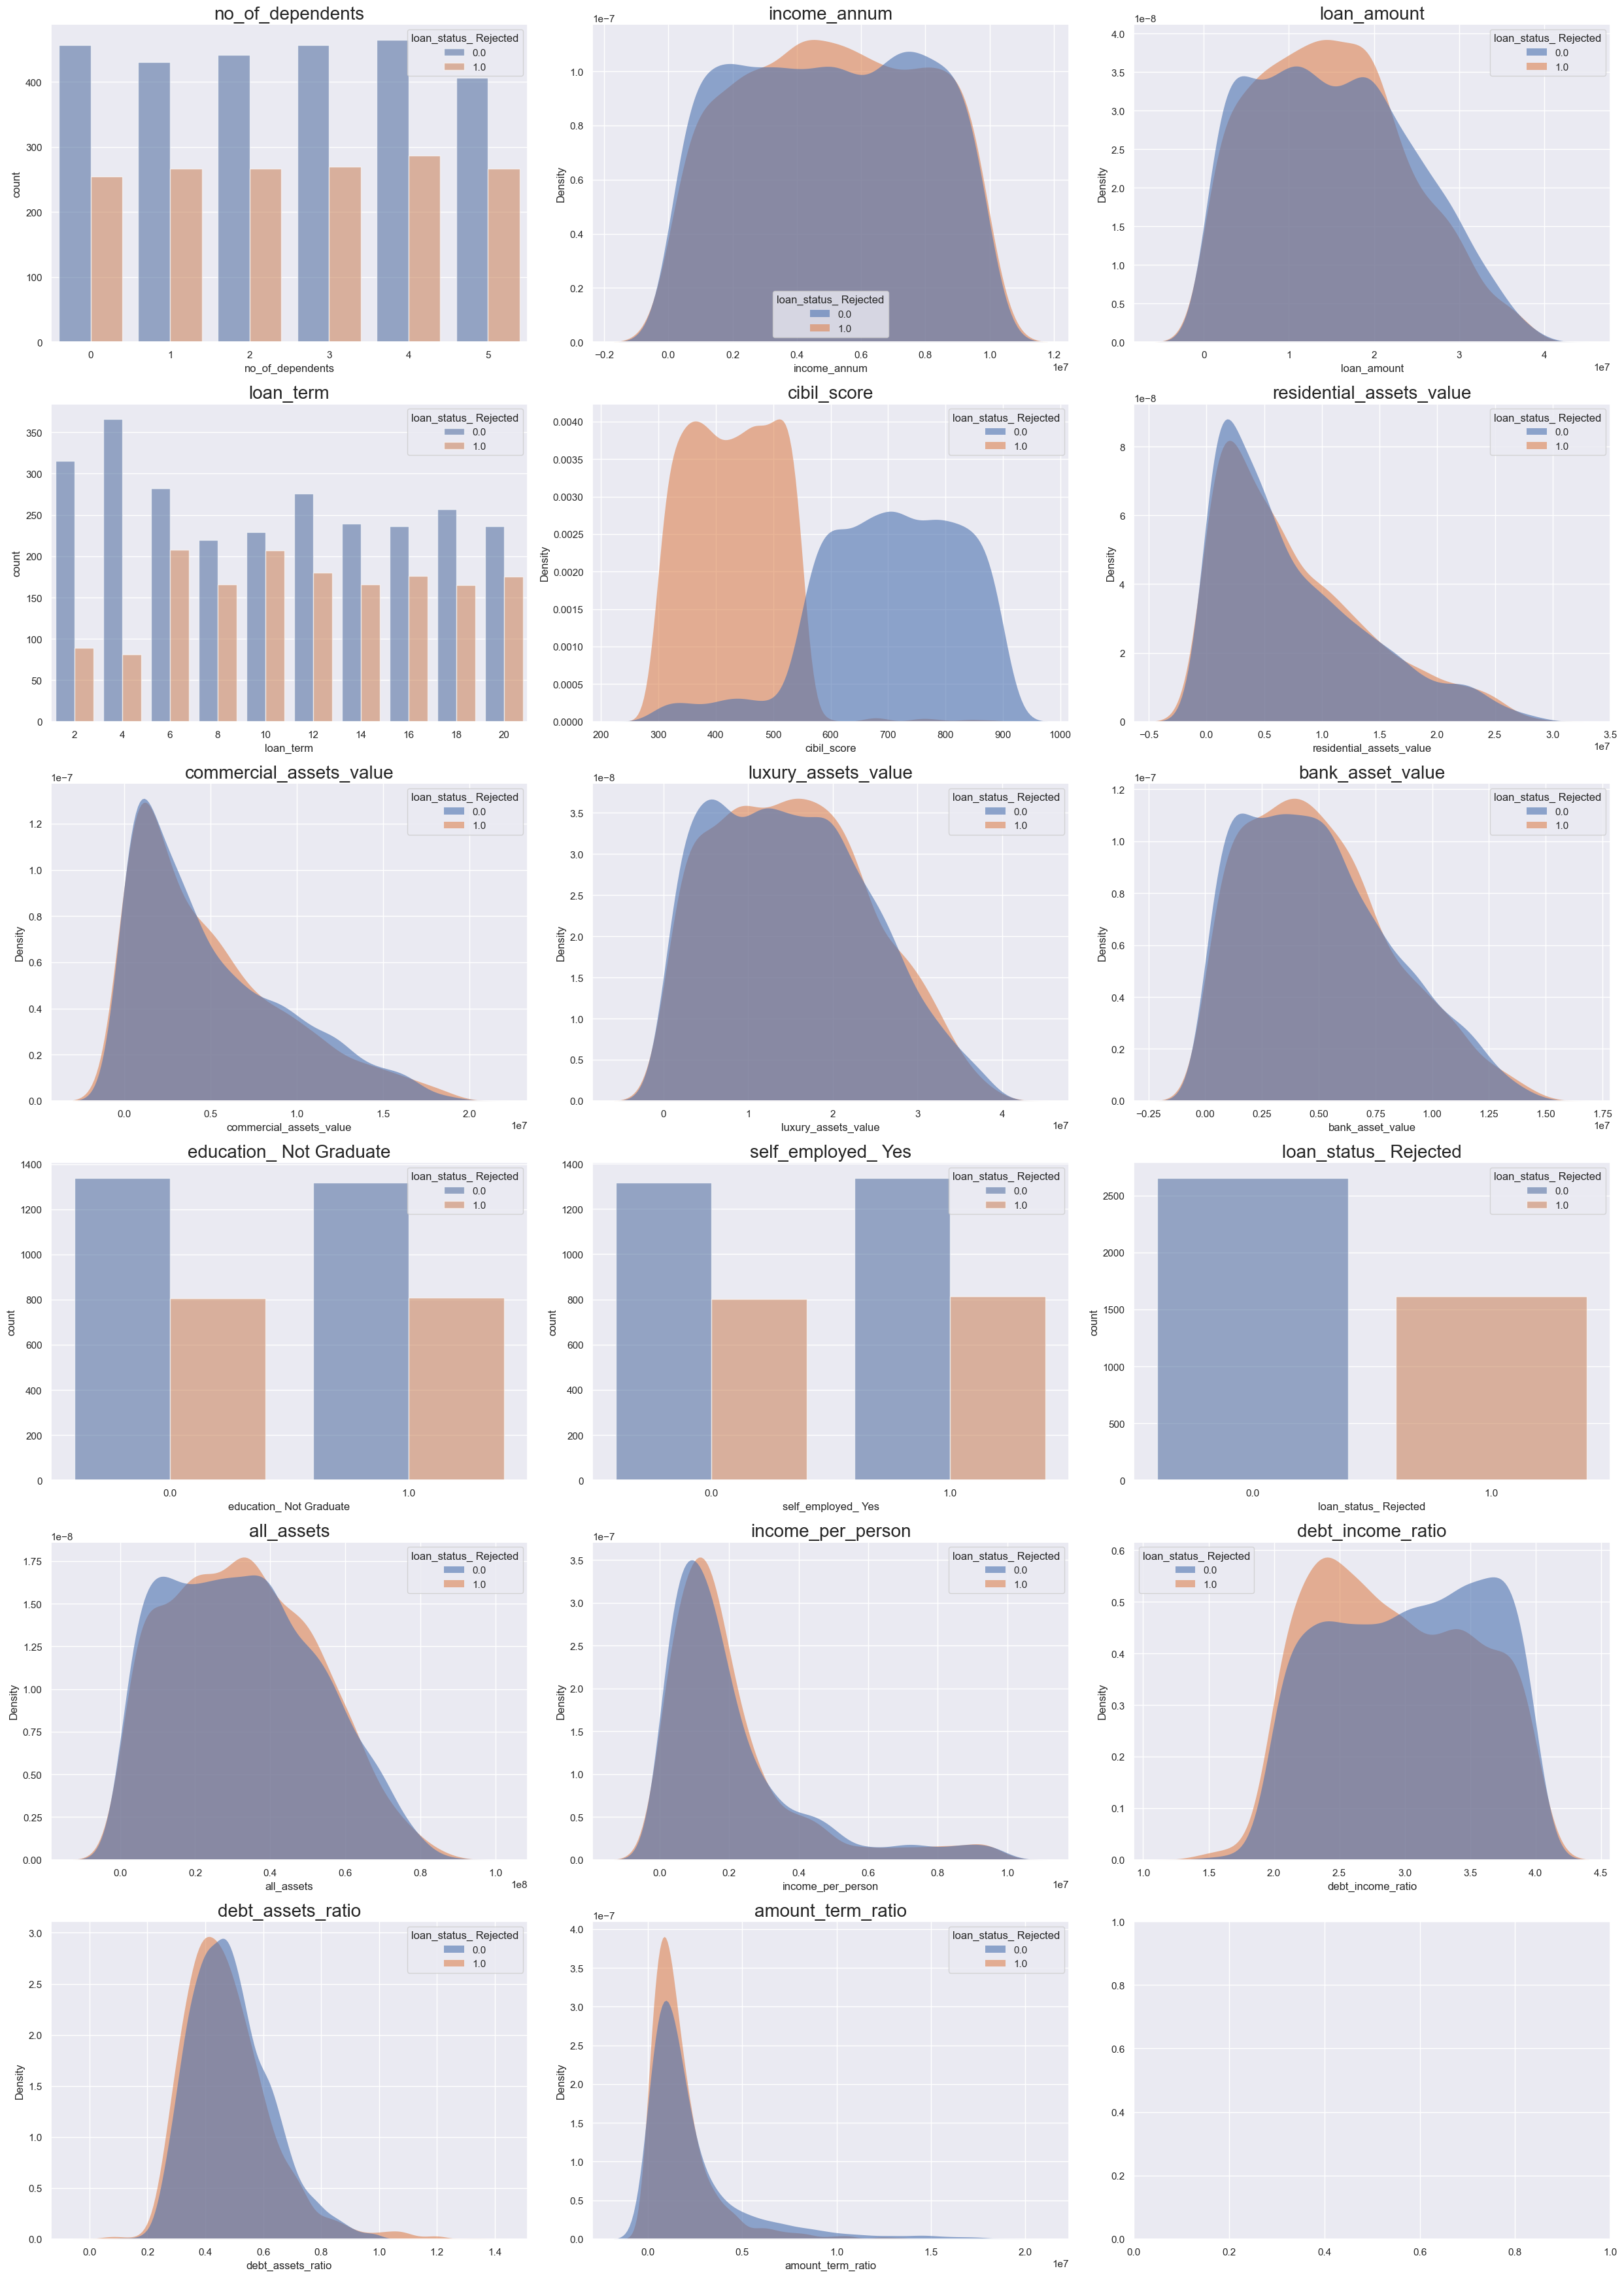

In [18]:
fig, axes = plt.subplots(6, 3, figsize=(25, 35), sharey=False)
axes = axes.flatten()

for i, col in enumerate(df_clean.columns):
    if col in ['no_of_dependents', 'self_employed_ Yes', 'loan_status_ Rejected', 'education_ Not Graduate', 'loan_term']:
        # sns.histplot(data=df_clean, x=col, hue="loan_status_ Rejected", ax=axes[i], shrink=.8)
        sns.countplot(data=df_clean, x=col, hue="loan_status_ Rejected", ax=axes[i], alpha=.6)
        
    else: 
        sns.kdeplot(data=df_clean, x=col, ax=axes[i], hue="loan_status_ Rejected", fill=True, common_norm=False, alpha=.6, linewidth=0)

    axes[i].set_title(col, fontsize=20)

plt.tight_layout()
plt.show()

- features like amount_term_ratio, income_per_person, commercial_assets_value, residential_assets_value, bank_asset_value, and luxury_assets_value are  right-skewed(log-normal distribution), with almost no visible distribution differences between accepted and rejected loans.
 
- cibil_score appears to be the most predictive feature, showing a clear separation between accepted and rejected loans, especially in the 500–600 range.

- debt_income_ratio shows a slight shift in peak density between the two loan outcomes.

- loan_term may also carry predictive value — loans with shorter terms (2–4 months) are rarely rejected.

- education and self_employment status show no meaningful impact on loan approval in this dataset.

### Outliers detection

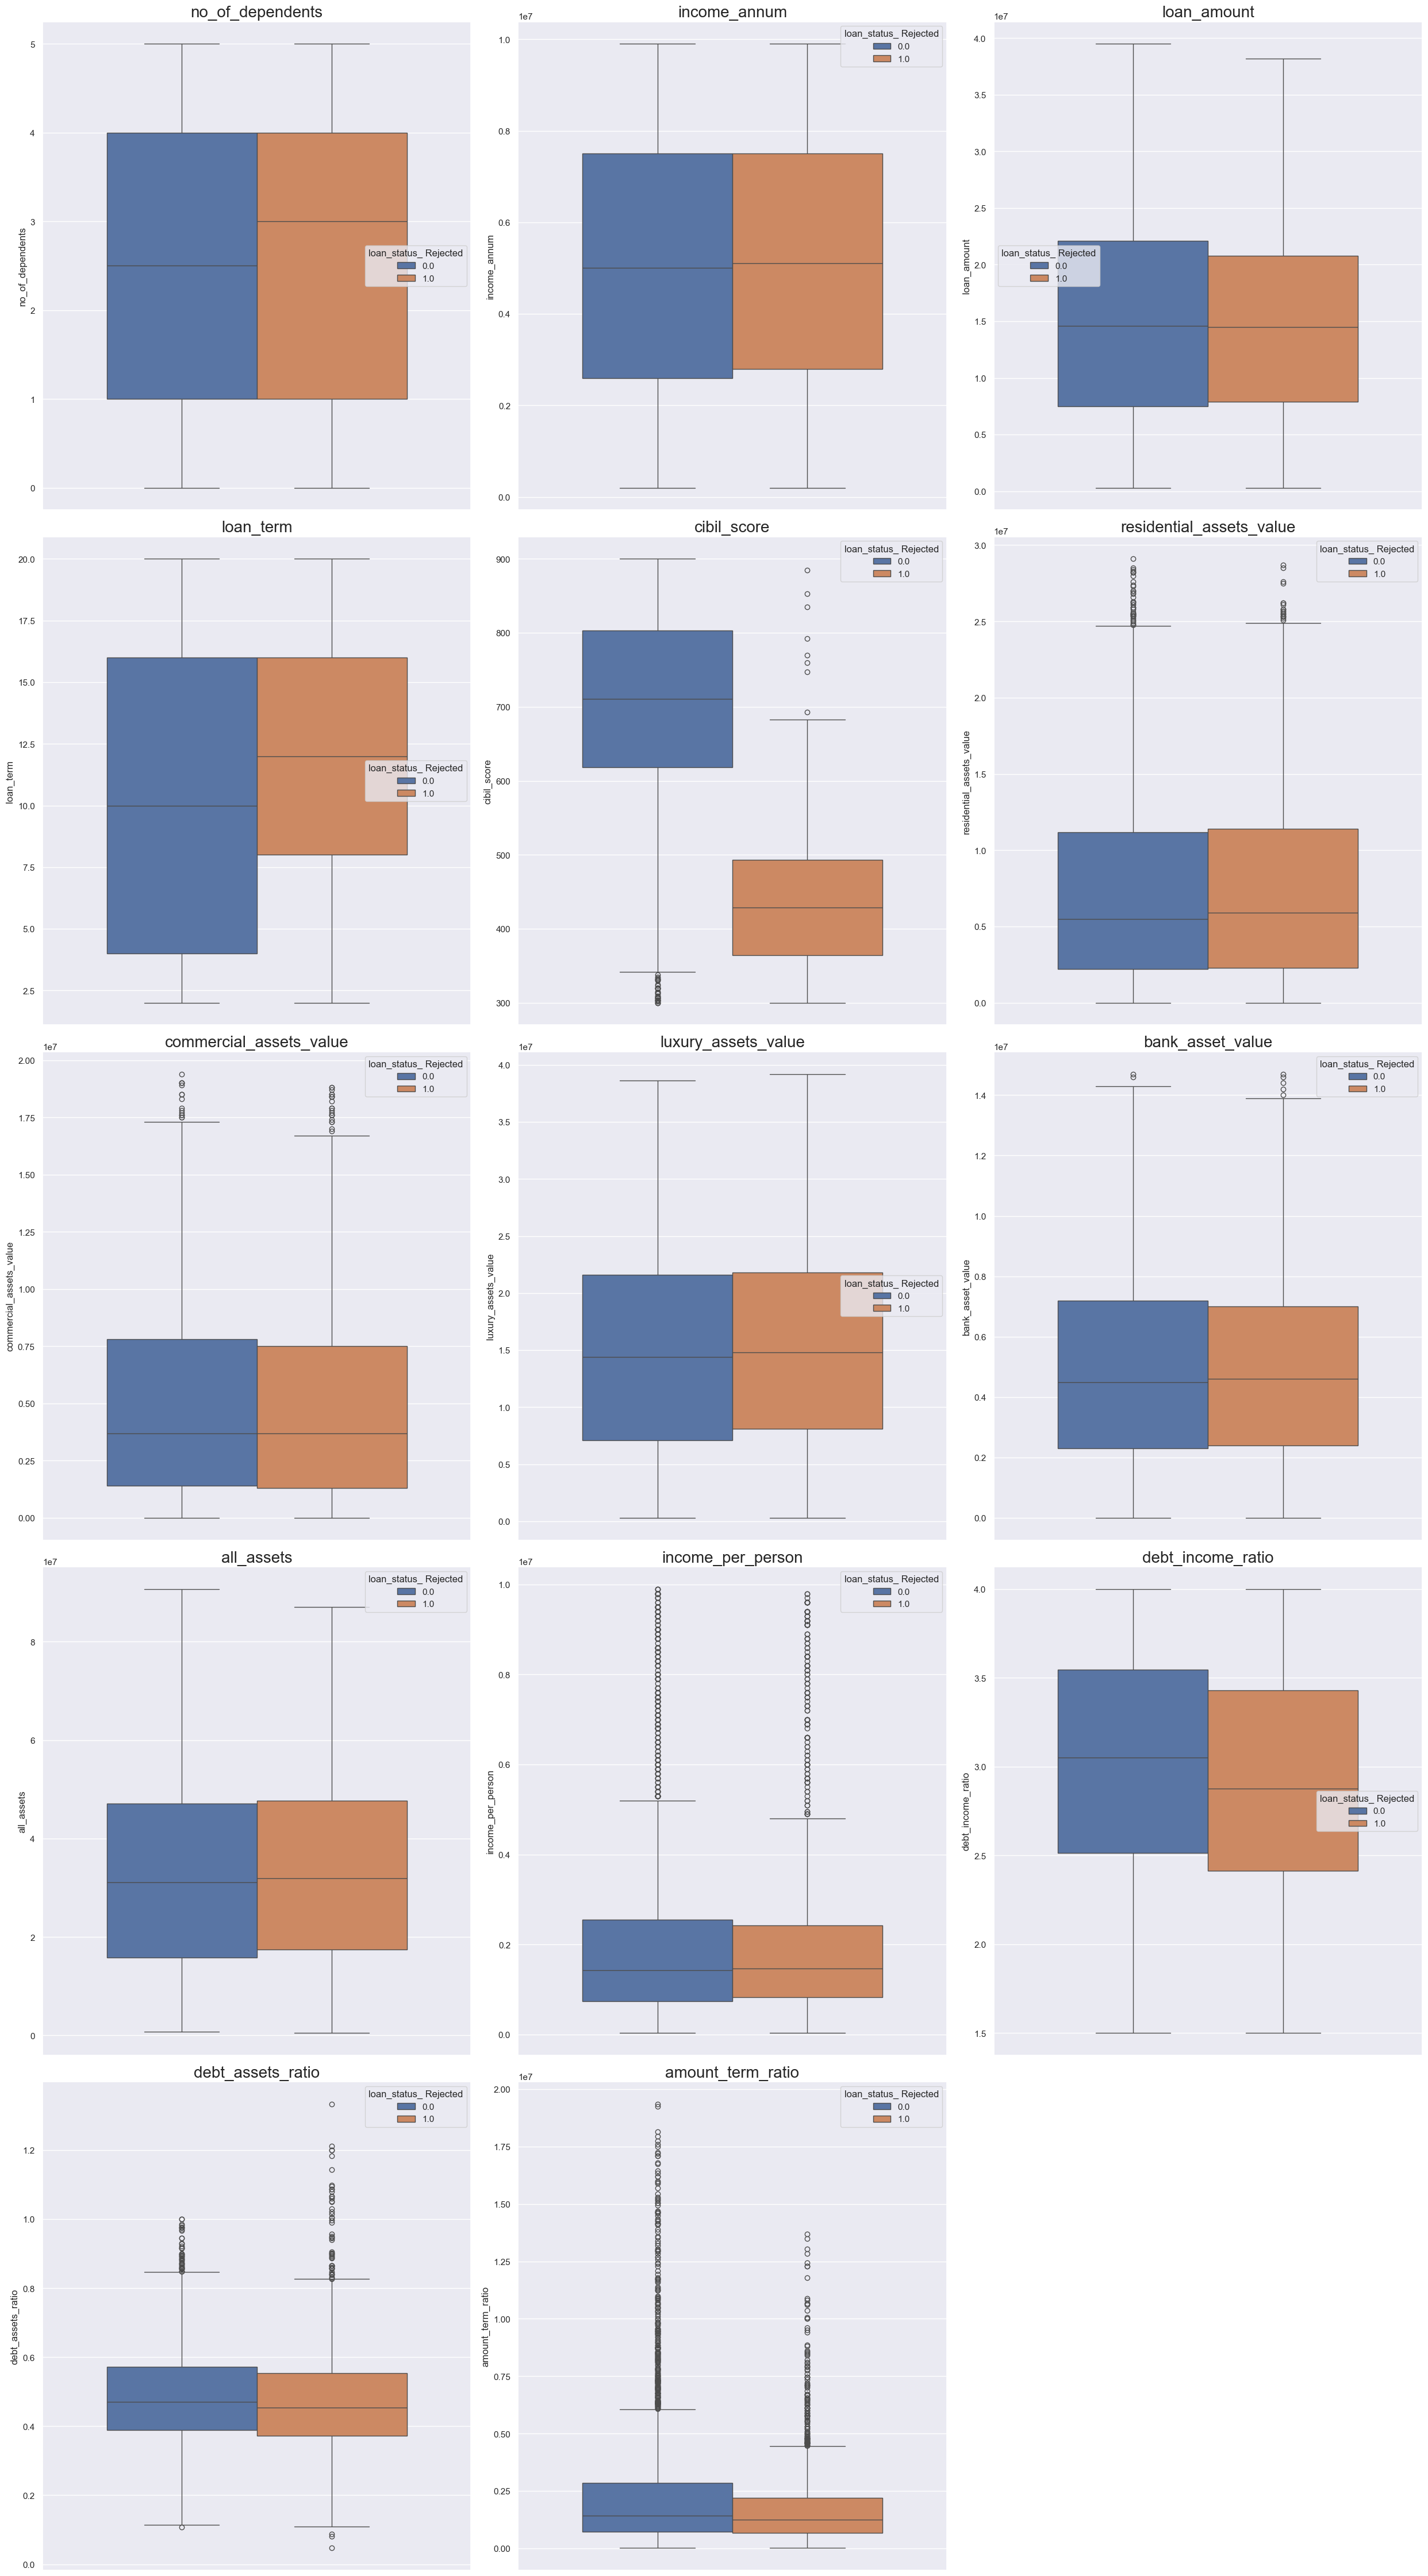

In [19]:
cols_to_plot = [col for col in df_clean.columns if col not in ['education_ Not Graduate', 'self_employed_ Yes', 'loan_status_ Rejected']]
n_cols = len(cols_to_plot)

# Create subplots
rows = (n_cols + 1) // 3
fig, axes = plt.subplots(rows, 3, figsize=(25, 9 * rows), sharey=False)
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.boxplot(data=df_clean, hue="loan_status_ Rejected",  y=col, ax=axes[i], width=0.7, showcaps=True)
    axes[i].set_title(col, fontsize=20)

# Remove unused subplots, if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Boxplots show minimal differences in the distributions of features like income, commercial assets value, luxury assets value, residential assets value, bank assets value, total assets, and income per person across loan status groups (rejected vs. accepted).

- A considerable number of outliers are present in residential, commercial, and bank asset values. The most pronounced outliers are observed in the debt-to-assets ratio and the amount-to-term ratio.

These outliers will be further examined to determine appropriate handling strategies for modeling.

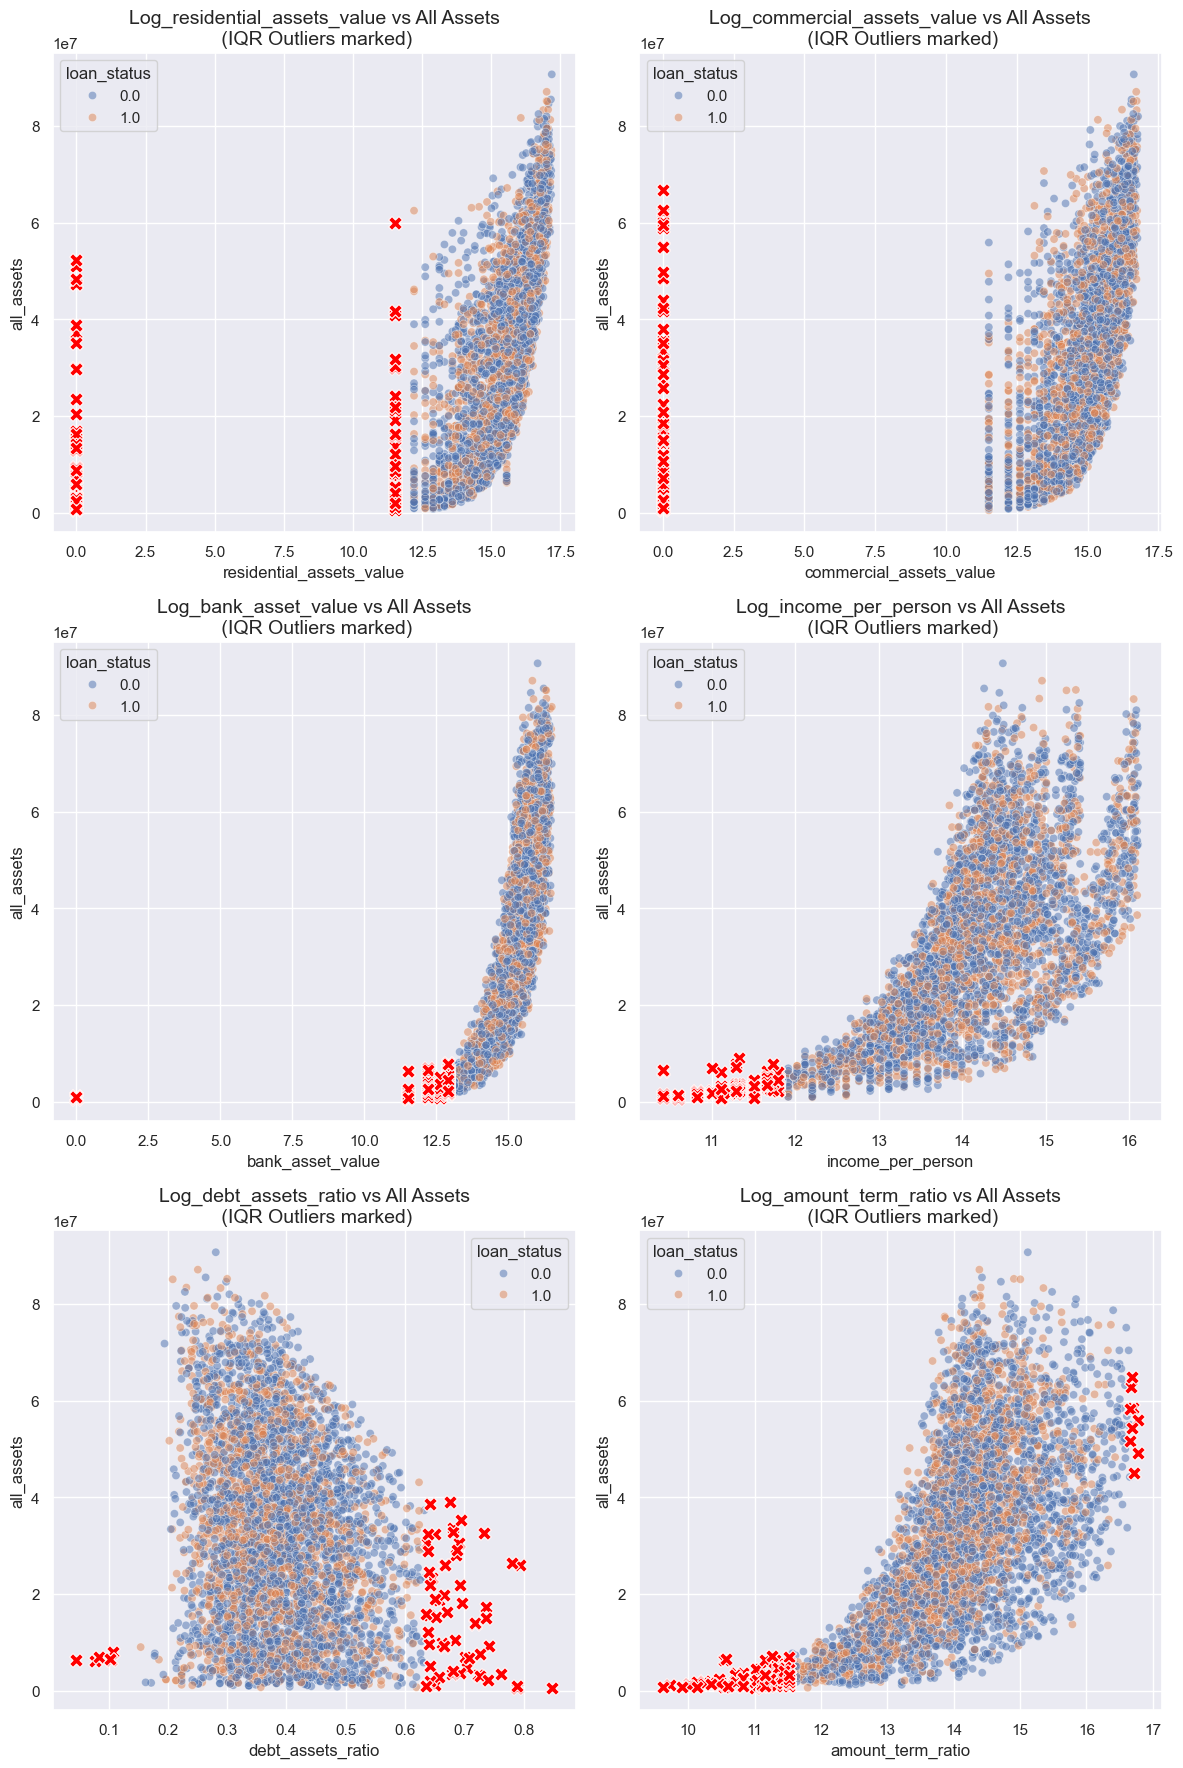

In [20]:
def detect_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1        
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR        
    return (series < lower_bound) | (series > upper_bound)


cols_to_plot = [col for col in df_clean.columns if col not in [
    'education_ Not Graduate', 'self_employed_ Yes', 'loan_status_ Rejected',
    'loan_term', 'luxury_assets_value', 'loan_amount', 'income_annum',
    'no_of_dependents', 'debt_income_ratio', 'all_assets', 'cibil_score'
]]

n_cols = len(cols_to_plot)
rows = (n_cols + 1) // 2

fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows), sharey=False)
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    x_vals = np.log1p(df_clean[col]) 

    plot_df = pd.DataFrame({
        col: x_vals,
        'all_assets': df_clean['all_assets'],
        'loan_status': df_clean["loan_status_ Rejected"]
    })

    # Outliers detection
    outliers_mask = detect_iqr_outliers(plot_df[col])
    plot_df['is_outlier'] = outliers_mask

    # Main data plot
    sns.scatterplot(data=plot_df[~plot_df['is_outlier']], x=col, y='all_assets', hue='loan_status', alpha=0.5, ax=axes[i], legend=True)
    # Outliers plot
    sns.scatterplot(data=plot_df[plot_df['is_outlier']], x=col, y='all_assets',  color='red', s=100, marker='X', ax=axes[i], legend=False)

    axes[i].set_title(f'Log_{col} vs All Assets\n (IQR Outliers marked)', fontsize=14)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**Based on boxplots and scatterplots (w.r.t. all_assets), I analyzed potential outliers in the following features:**
- Residential Assets Value
- Commercial Assets Value
- Bank Assets Value
- Income Per Person
- Debt Assets Ratio
- Amount Term Ratio
For all features, I applied log-transformation before detecting outliers via the IQR method, as the original distributions were right-skewed.

**Key Observations:**
- Zero values consistently appeared as outliers in Residential, Commercial, and Bank Assets, and should be treated with caution.
- Most non-zero outliers identified by IQR did not visually stand out in scatterplots — they followed the overall trend and did not disrupt the data structure.
- Outliers in Debt Assets Ratio and Amount Term Ratio (e.g., near 0 or >0.6) were minor and not visually problematic.
- In Income Per Person, flagged low-end values were consistent with the general distribution.

**Conclusion:**
Aside from zero-valued points, IQR-based outliers did not show significant deviation in scatterplots. These findings suggest that only zero-valued records may require special treatment or deeper investigation in downstream analysis.

### Features Correlation

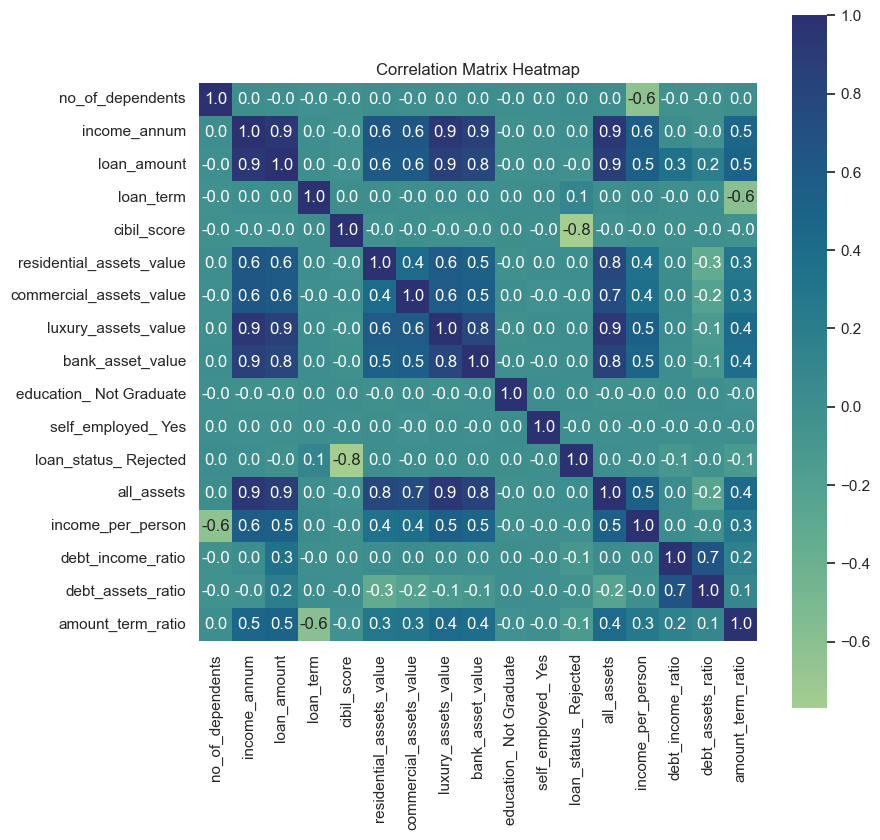

In [21]:
plt.figure(figsize=(9, 9))
correlation_matrix = df_clean.corr()
sns.heatmap(correlation_matrix, cmap="crest", annot=True, fmt=".1f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

Potential Multicollinearity:
- luxury_assets_value correlates highly with residential_assets_value(0.6) and commercial_assets_value(0.6) and bank_assets_value(0.8).
This could indicate overlapping or redundant information, leading to multicollinearity issues in modeling.
- Similarly, income_annum and loan_amount are highly correlated with all asset-related variables, which could also impact model performance

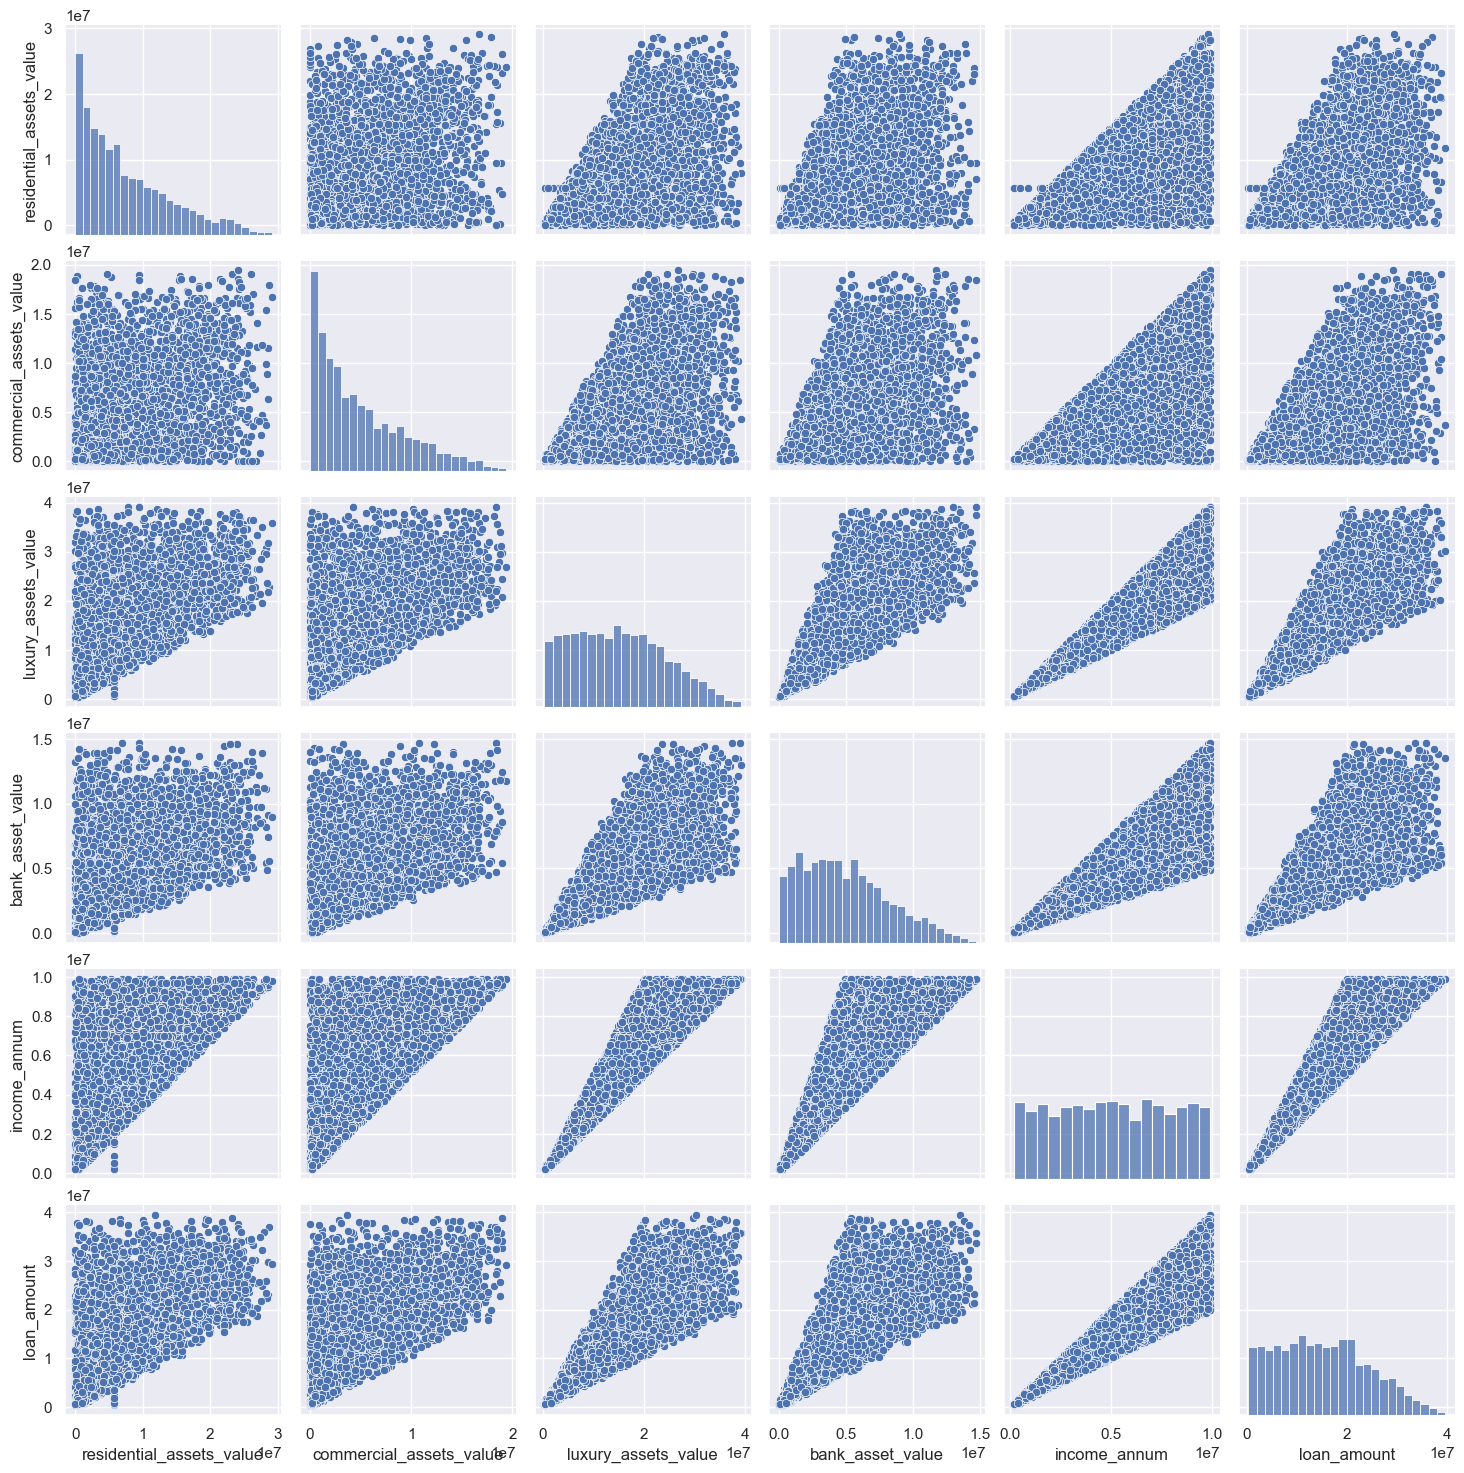

In [22]:
sns.pairplot(df_clean[['residential_assets_value',  'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'income_annum', 'loan_amount']])
plt.show()

- The analysis reveals strong positive correlations, particularly between income_annum and loan_amount, as well as between income_annum and bank_assets_value. However, some feature pairs, such as loan_amount and residential_assets_value, show no clear relationship. Asset-related features, including residential_assets_value, commercial_assets_value, and luxury_assets_value, exhibit overlapping information, which indicates multicollinearity.

- The triangular shapes in the scatter plots represent bounded relationships between variables, commonly observed in financial datasets.

### VIF

In [23]:
def check_vif(df):
  df = df.select_dtypes(include=['number'])
  vif = pd.DataFrame()
  vif["feature"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
  return vif

In [24]:
vif_count = check_vif(df_clean.drop(['loan_status_ Rejected'], axis=1))
vifs = vif_count.sort_values('VIF', ascending=False)
vifs.reset_index(drop=True, inplace=True)

C:\Users\Татьяна\Desktop\GitHub\Data-Analysis\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [25]:
vifs

feature    VIF
0   residential_assets_value    inf
1    commercial_assets_value    inf
2        luxury_assets_value    inf
3           bank_asset_value    inf
4                 all_assets    inf
5               income_annum 149.40
6          debt_income_ratio  83.95
7          debt_assets_ratio  60.19
8                loan_amount  44.99
9                cibil_score  11.76
10                 loan_term   8.45
11          no_of_dependents   7.38
12         income_per_person   7.21
13         amount_term_ratio   4.28
14        self_employed_ Yes   2.00
15   education_ Not Graduate   1.98

As observed earlier, features such as residential_assets_value, commercial_assets_value, luxury_assets_value, and bank_asset_value showed extremely high correlation coefficients, and now we see their corresponding VIF values are inf, indicating perfect multicollinearity. To address this, we will drop these features and retain only all_assets.

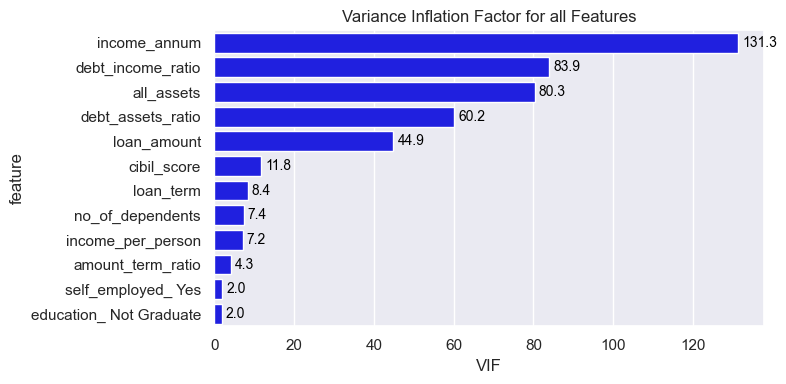

In [34]:
vif_count2 = check_vif(df_clean.drop(['residential_assets_value', 'commercial_assets_value',
                                     'luxury_assets_value', 'bank_asset_value', 'loan_status_ Rejected'], axis=1))
cutted_vif = vif_count2.sort_values('VIF', ascending=False)
cutted_vif.reset_index(drop=True, inplace=True)

sns.set()
plt.figure(figsize=(8, 4))
ax = plt.gca()
sns.barplot(data=cutted_vif, y='feature', x='VIF', color='blue', ax=ax)

# Add VIF values as text labels on the bars
for i, row in cutted_vif.iterrows():
    ax.text(x=row['VIF']+1, y=i, s=f"{row['VIF']:.1f}", 
            ha='left', va='center', fontsize=10, color='black')

plt.title('Variance Inflation Factor for all Features')
plt.tight_layout()
plt.show()


- VIF (Variance Inflation Factor) scores are high for nearly half of the features, mainly due to strong correlations between income_annum, loan_amount, and their derived features like debt_income_ratio and debt_assets_ratio.
- Elevated VIF values suggest multicollinearity, which can distort coefficient estimates in linear models and reduce interpretability.
- Due to the high VIF scores and the relatively small number of features I plan to conside tree-based models, which are more robust to multicollinearity.

### Feature Importance via Mutual Information

In [53]:
def count_mi_scores(X, y, entropy_estimate):
    """
    Calculates mutual information scores between features and a discrete target,
    and expresses how much information each feature provides about the target 
    as a percentage of the target's estimated entropy.

    Returns:
    --------
    pd.DataFrame
        DataFrame with mutual information scores and corresponding
        percentage of explained target entropy, sorted descending.
    """
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    info_percent = 100 * mi_scores / entropy_estimate

    mi_df = pd.DataFrame({
        'mi_scores': mi_scores,
        'info_percent': info_percent
    }, index=X.columns).sort_values(by='info_percent', ascending=False)

    return mi_df

In [54]:
def plot_mi_scores(df_scores):
    """
    Plots mutual information scores as a horizontal bar chart,
    annotated with the percentage of target information each feature explains.
    """
    df_sorted = df_scores.sort_values(by='mi_scores', ascending=True)
    scores = df_sorted['mi_scores']
    info_percent = df_sorted['info_percent']
    ticks = df_sorted.index
    width = np.arange(len(scores))

    # Plot
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.barh(width, scores, color='skyblue')
    ax.set_yticks(width)
    ax.set_yticklabels(ticks)
    ax.set_title("Proportion of Target Information Captured via Mutual Information", fontsize=14)
    ax.set_xlabel("MI Score")
    
    # Annotate with info_percent
    for i, (score, percent) in enumerate(zip(scores, info_percent)):
        ax.text(x=score + 0.01, y=i, s=f"{percent:.1f}%", 
                ha='left', va='center', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()

In [55]:
probs = df_clean['loan_status_ Rejected'].value_counts(normalize=True)
shannon_entropy = entropy(probs, base=np.e)

In [56]:
mi_df = count_mi_scores(df_clean.drop(['loan_status_ Rejected'], axis=1), df_clean['loan_status_ Rejected'], entropy_estimate=shannon_entropy)

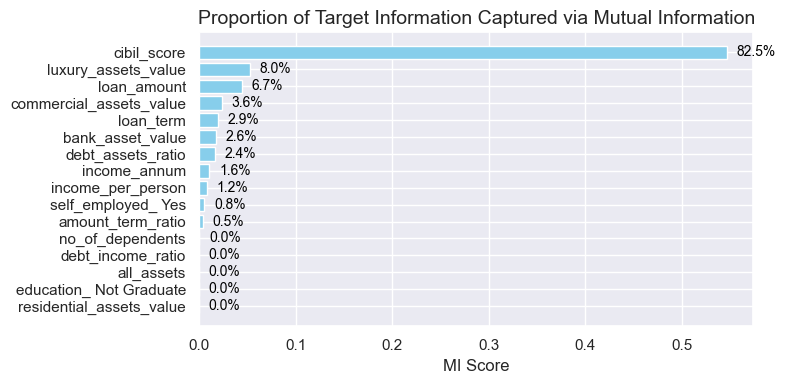

In [57]:
plot_mi_scores(mi_df)

As observed earlier in the distribution plots colored by target, there is a clear relationship between CIBIL Score and accepted/rejected loans. Interestingly, the second most informative feature according to mutual information is luxury_assets_value (8%), followed by loan_amount, which is quite understandable. Features such as all_assets, education, no_of_dependents, and residential_assets_ratio showed 0% mutual information with the target.